# ARIMA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

In [8]:
df = pd.read_csv('data/2yrs_data.csv')

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')

scaler = MinMaxScaler(feature_range=(0, 1))
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])

df = df.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df = df.drop(columns=['index']).drop_duplicates().reset_index(drop=True)

df.head(5)

,Hour,is_weekend,is_holiday,Day,Month,Year,hourly_active_power
0,17,1,0,16,12,2006,0.378494
1,18,1,0,16,12,2006,0.551144
2,19,1,0,16,12,2006,0.514685
3,20,1,0,16,12,2006,0.493991
4,21,1,0,16,12,2006,0.460654


In [ ]:
train_size = int(len(df) * 0.8)  # 80% for training
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop('hourly_active_power', axis=1)  # Features
y_train = train['hourly_active_power']               # Target ##
X_test = test.drop('hourly_active_power', axis=1)    # Features
y_test = test['hourly_active_power']                 # Target ##

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
df = pd.read_csv('data/2yrs_data.csv')

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract datetime features
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year

# Aggregate data to hourly sums
df_hourly = df.groupby(['Year', 'Month', 'Day', 'Hour']).agg({'Global_active_power': 'sum'}).reset_index()

# Create 'DateTime' column from 'Year','Month','Day','Hour'
df_hourly['DateTime'] = pd.to_datetime(df_hourly[['Year', 'Month', 'Day', 'Hour']])

# Set 'DateTime' as index
df_hourly = df_hourly.set_index('DateTime')

# Scale 'Global_active_power'
scaler = MinMaxScaler(feature_range=(0, 1))
df_hourly['hourly_active_power'] = scaler.fit_transform(df_hourly[['Global_active_power']])

# Drop unnecessary columns
df_hourly = df_hourly.drop(columns=['Global_active_power', 'Year', 'Month', 'Day', 'Hour'])

# Split data into train and test sets
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test = df_hourly.iloc[train_size:]

y_train = train['hourly_active_power']
y_test = test['hourly_active_power']

# Build ARIMA model with order (4, 0, 6)
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(y_train, order=(4, 0, 6))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameter

                                SARIMAX Results                                
Dep. Variable:     hourly_active_power   No. Observations:                 7252
Model:                  ARIMA(4, 0, 6)   Log Likelihood                6113.792
Date:                 Wed, 04 Dec 2024   AIC                         -12203.585
Time:                         13:15:24   BIC                         -12120.916
Sample:                              0   HQIC                        -12175.149
                                - 7252                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1477      0.004     35.323      0.000       0.139       0.156
ar.L1          0.2858      0.077      3.710      0.000       0.135       0.437
ar.L2          0.6939      0.087      7.998 

In [29]:
forecast

7252    0.201041
7253    0.197320
7254    0.171447
7255    0.125551
7256    0.093345
          ...   
9060    0.147692
9061    0.147692
9062    0.147692
9063    0.147692
9064    0.147692
Name: predicted_mean, Length: 1813, dtype: float64

RMSE (scaled data): 0.17985147868180096
MAE (scaled data): 0.13853483324976226


/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


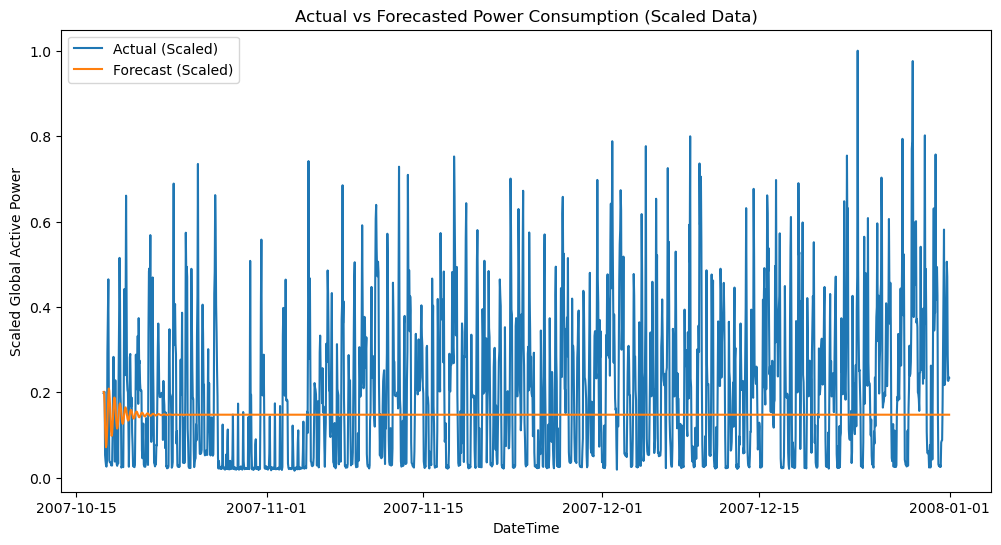

In [33]:
# Forecast values
n_periods = len(y_test)
forecast = model_fit.forecast(steps=n_periods)

# Convert forecast to pandas Series
forecast_series = pd.Series(forecast, index=y_test.index)

# Evaluate the forecast against y_test on scaled data
rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)
print(f'RMSE (scaled data): {rmse}')
print(f'MAE (scaled data): {mae}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual (Scaled)')
plt.plot(y_test.index, forecast, label='Forecast (Scaled)')
plt.legend()
plt.xlabel('DateTime')
plt.ylabel('Scaled Global Active Power')
plt.title('Actual vs Forecasted Power Consumption (Scaled Data)')
plt.show()

## Pre-processing

In [2]:
# Prediction
PREDICTION_TERM = 'Global_active_power'

# Graph
width = 14
height = 6

# Colors
coolwarm = cm.coolwarm
red = coolwarm(0.9)
blue = coolwarm(0.1)

In [3]:
# Load the CSV file
data = pd.read_csv('2yrs_data.csv')

# Drop unnecessary columns
data = data.drop(columns=['Global_reactive_power',
                          'Voltage', 'Global_intensity', 
                          'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])

# # Combine Date and Time to index
# data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
# data.set_index('datetime', inplace=True)

# Convert to correct time format
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.strftime('%H:%M')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Create a time grid for first date (not starting at 00:00)
first_date = data['Date'].min()
first_time = data[data['Date'] == first_date]['Time'].min()
first_date_times = pd.date_range(start=first_time, end="23:59", freq='min').time
first_date_grid = pd.DataFrame(
    [(first_date, time) for time in first_date_times], 
    columns=['Date', 'Time']
)

# Create a time grid for all other dates (starting at 00:00)
other_dates = pd.date_range(start=data['Date'].min(), end=data['Date'].max(), freq='D')
other_date_times = pd.date_range(start="00:00", end="23:59", freq='min').time
other_dates_grid = pd.DataFrame(
    [(date, time) for date in other_dates[1:] for time in other_date_times],
    columns=['Date', 'Time']
)

# Combine both grids
full_grid = pd.concat([first_date_grid, other_dates_grid], ignore_index=True)
full_grid['Time'] = pd.to_datetime(full_grid['Time'], format='%H:%M:%S').dt.strftime('%H:%M')

# Reset data so that it includes missing time
data = full_grid.merge(data, on=['Date', 'Time'], how='outer').sort_values(by=['Date', 'Time']).reset_index(drop=True)

# # Impute the NaN 'is_holiday' based on the same day
# holiday_dates = data[data['is_holiday']==1]['Date'].to_list()
# holiday_dates = pd.to_datetime(holiday_dates).date
# data['is_holiday'] = data['Date'].isin(holiday_dates).astype(int)

# # Impute the NaN 'is_weekend' based on the same day
# data['Date'] = pd.to_datetime(data['Date'])
# data['is_weekend'] = (data['Date'].dt.weekday >= 5).astype(int)

## Data Analysis

In [4]:
missing_data = data[data[PREDICTION_TERM].isna()]
print(len(missing_data), len(data))
print(len(missing_data) / len(data)) # 0.3 percent of missing data

4070 1074636
0.003787328918815301


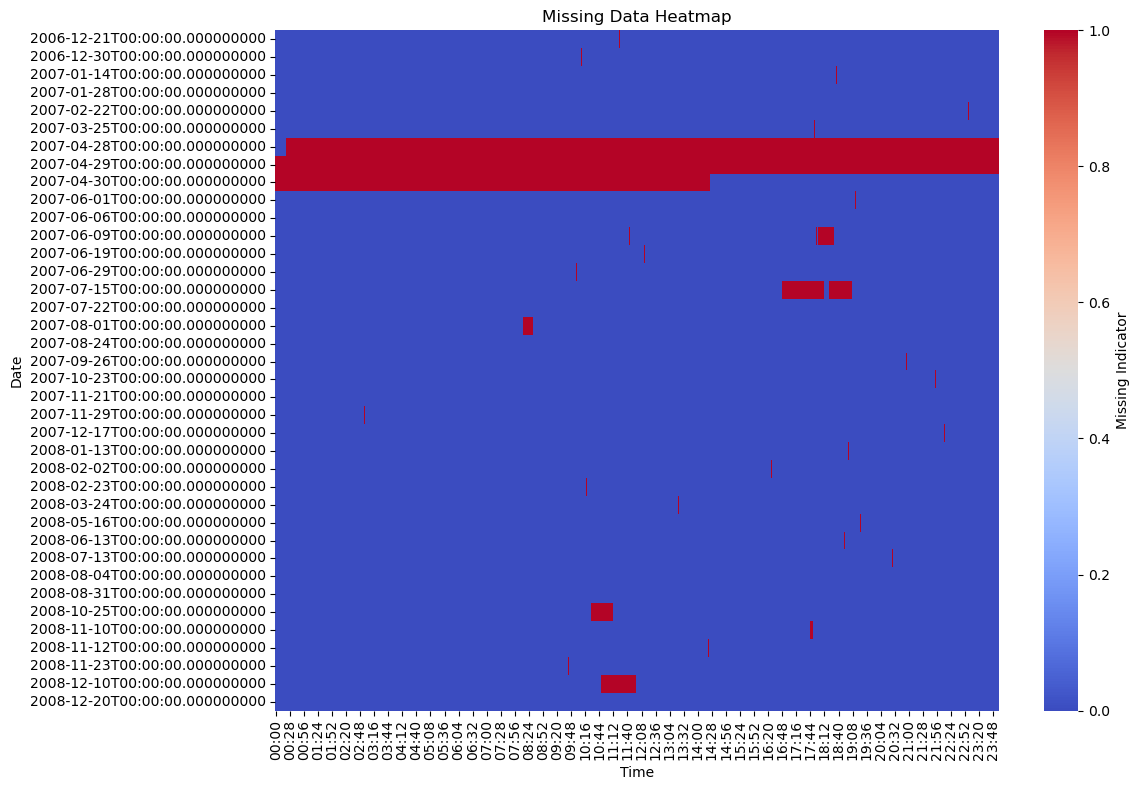

In [6]:
# Inspect missing values based on date time
heatmap_data = missing_data.pivot_table(index='Date', \
                                        columns='Time', values=PREDICTION_TERM, \
                                            aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Missing Indicator'})
plt.title('Missing Data Heatmap')
plt.ylabel('Date')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# What happened during 4/28/2007 to 5/01/2007 to this household?
# Political activity due to presidential election?

## Modeling

In [8]:
# ===== Reminder and Checks =====

# Display normal data
display(data.head(3))

# Display missing data
display(data[data[PREDICTION_TERM].isna()].head(3))

# Display earliest data
display(data.sort_values(by=['Date', 'Time'], ascending=True).head(3))

# Display latest data
display(data.sort_values(by=['Date', 'Time'], ascending=False).head(3))

,Date,Time,Global_active_power
0,2006-12-16,17:24,4.216
1,2006-12-16,17:25,5.360
2,2006-12-16,17:26,5.374


,Date,Time,Global_active_power
6839,2006-12-21,11:23,NaN
6840,2006-12-21,11:24,NaN
19724,2006-12-30,10:08,NaN


,Date,Time,Global_active_power
0,2006-12-16,17:24,4.216
1,2006-12-16,17:25,5.360
2,2006-12-16,17:26,5.374


,Date,Time,Global_active_power
1074635,2008-12-31,23:59,0.482
1074634,2008-12-31,23:58,0.480
1074633,2008-12-31,23:57,0.482


<Figure size 1400x600 with 0 Axes>

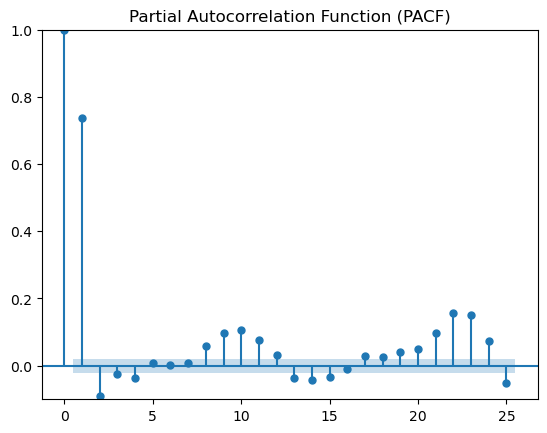

In [4]:
# Plot PACF - p

plt.figure(figsize=(14, 6))
plot_pacf(df['hourly_active_power'], lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [5]:
# Check Stationary - d
# Augmented Dickey-Fuller test for stationarity

result = adfuller(df['hourly_active_power'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("The process is stationary.")
else:
    print("The process is not stationary.")

ADF Statistic: -10.20833772020902
p-value: 5.72532443239737e-18
The process is stationary.


<Figure size 1400x600 with 0 Axes>

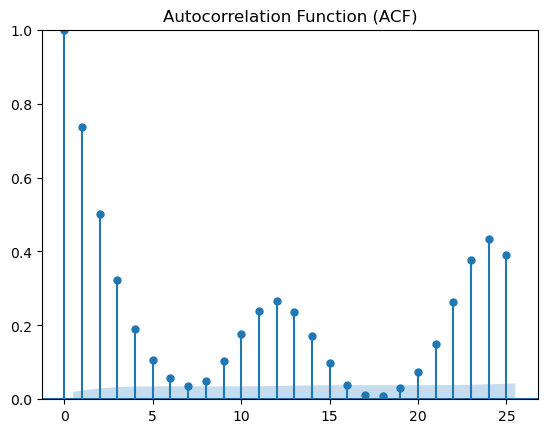

In [6]:
# Plot ACF - q

plt.figure(figsize=(14, 6))
plot_acf(df['hourly_active_power'], lags=25)
plt.ylim(0, 1)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 1400x600 with 0 Axes>

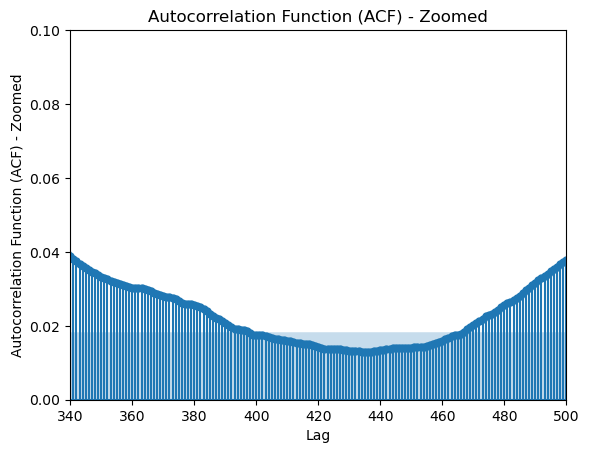

In [ ]:
# # Plot ACF with zoomed x-lim
# plt.figure(figsize=(width, height))
# plot_acf(data_temp[PREDICTION_TERM], lags=500)
# plt.xlim(340, 500)  # Set the x-limits to zoom in the specfic range of time local minima
# plt.ylim(0, 0.1)
# plt.title('Autocorrelation Function (ACF) - Zoomed')
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation Function (ACF) - Zoomed')
# plt.show()

In [4]:
# Orders
# p = [3, 5, 7]
# d = 0
# q = 435

order = (5, 0, 435)

## Data Processing

In [5]:
data['Timestamp'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))
data.set_index('Timestamp', inplace=True)  # Use the timestamp as the index

print(f"{data[PREDICTION_TERM].isna().sum()} NaN value remaining")
print(f"{len(data)} data in total")

4070 NaN value remaining
1074636 data in total


In [6]:
# Imputation: Last/Next year data

def year_based_imputation(df, col_name):
    df_copy = df.copy()
    for idx in df_copy[df_copy[col_name].isna()].index:  # Loop through missing values
        year = idx.year
        for offset in [-1, 1]:  # Check previous and next year
            new_year = year + offset
            try:
                candidate_index = idx.replace(year=new_year)
                if candidate_index in df_copy.index:
                    value = df_copy.at[candidate_index, col_name]
                    if not pd.isna(value):  # If valid value found, impute it
                        df_copy.at[idx, col_name] = value
                        break
            except ValueError:  # Handle invalid date replacements like 2/29 in non-leap years
                continue
                
    return df_copy

data_imputed1 = year_based_imputation(data, PREDICTION_TERM)
print(f"{data_imputed1[PREDICTION_TERM].isna().sum()} NaN value remaining")

0 NaN value remaining


<Figure size 1400x600 with 0 Axes>

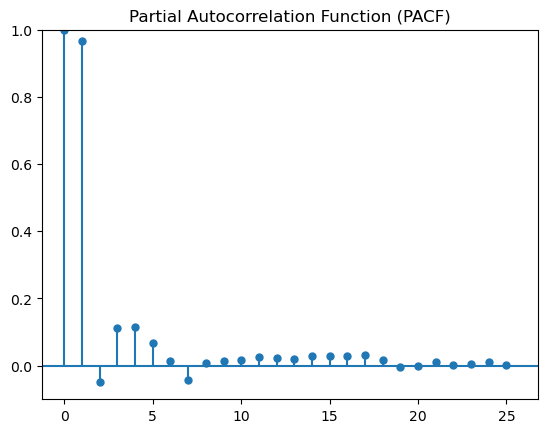

In [ ]:
# ===== Check if PACF Changes =====

plt.figure(figsize=(width, height))
plot_pacf(data_imputed1[PREDICTION_TERM], lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [7]:
# Imputation: Forward-Fill
data_imputed2 = data.copy(deep=True)
data_imputed2[PREDICTION_TERM] = data_imputed2[PREDICTION_TERM].ffill()

print(f"{data_imputed2.isna().sum()} NaN value remaining")

Date                   0
Time                   0
Global_active_power    0
dtype: int64 NaN value remaining


<Figure size 1400x600 with 0 Axes>

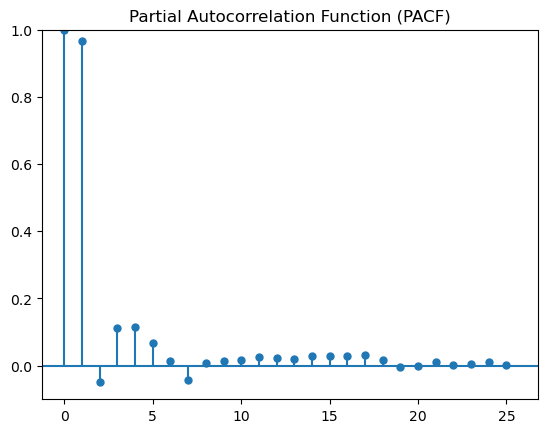

In [ ]:
# ===== Check if PACF Changes =====

plt.figure(figsize=(width, height))
plot_pacf(data_imputed2, lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [8]:
# Drop Missing Values

data_dropnan = data.dropna(subset=[PREDICTION_TERM])

print(f"{data_dropnan[PREDICTION_TERM].isna().sum()} NaN value remaining")

0 NaN value remaining


<Figure size 1400x600 with 0 Axes>

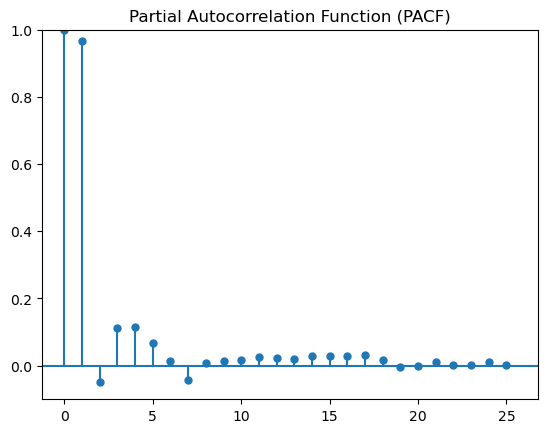

In [ ]:
# ===== Check if PACF Changes =====

plt.figure(figsize=(width, height))
plot_pacf(data_dropnan[PREDICTION_TERM], lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## ARIMA

### data_dropnan

<Figure size 1200x600 with 0 Axes>

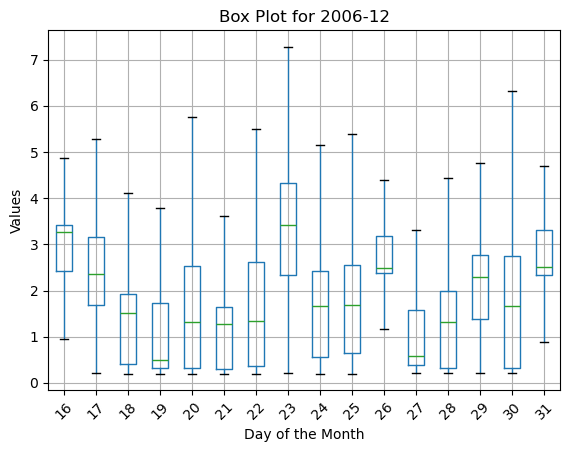

<Figure size 1200x600 with 0 Axes>

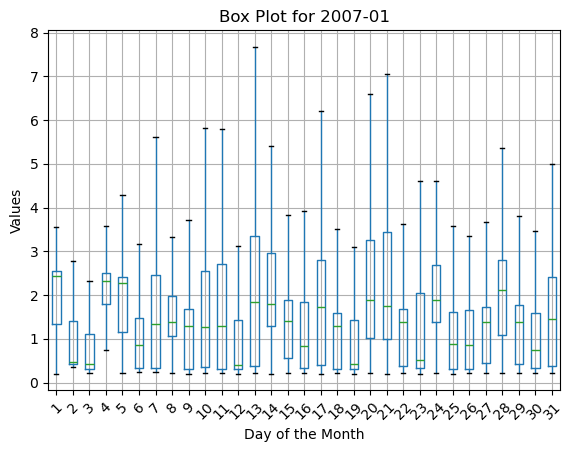

<Figure size 1200x600 with 0 Axes>

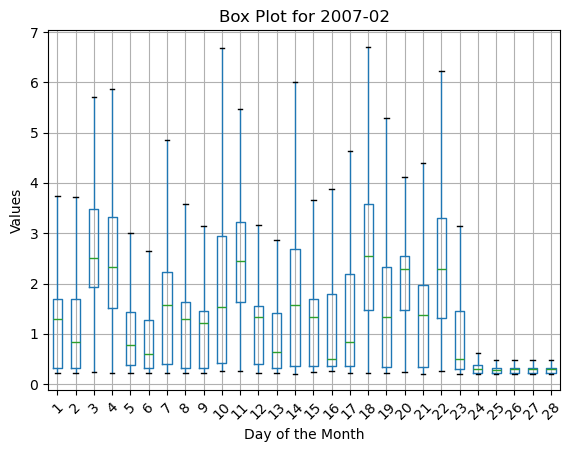

<Figure size 1200x600 with 0 Axes>

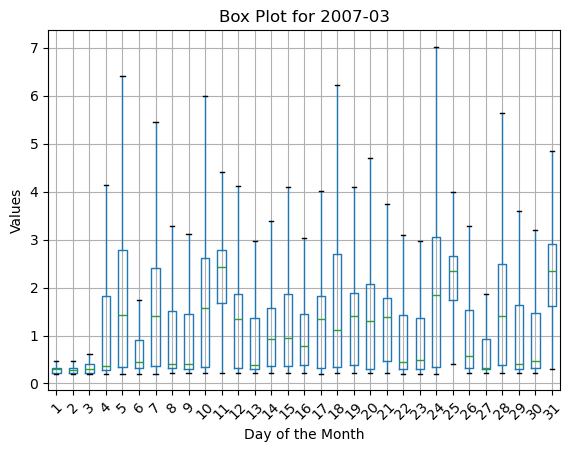

<Figure size 1200x600 with 0 Axes>

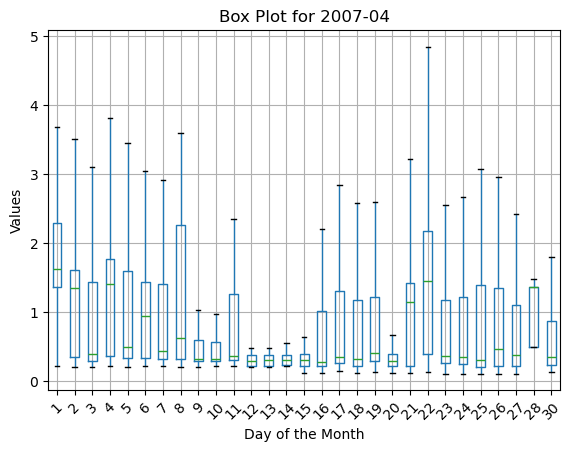

<Figure size 1200x600 with 0 Axes>

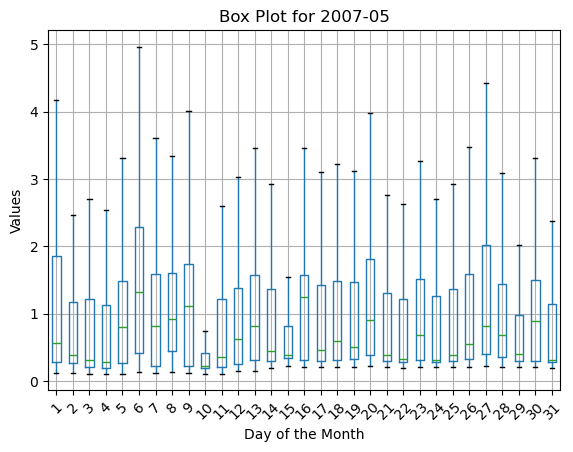

<Figure size 1200x600 with 0 Axes>

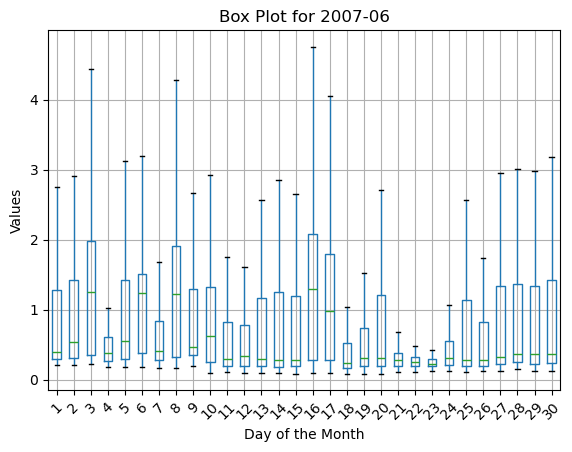

<Figure size 1200x600 with 0 Axes>

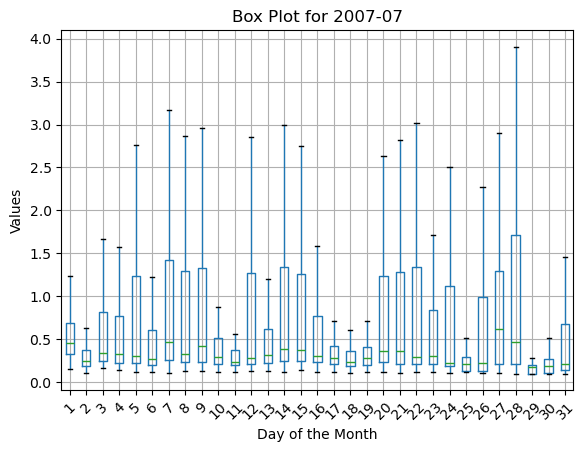

<Figure size 1200x600 with 0 Axes>

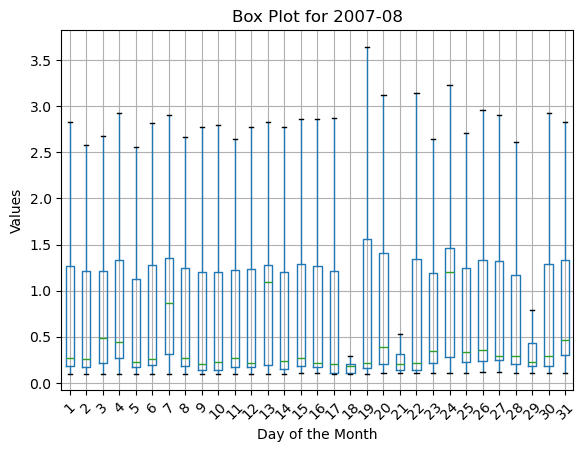

<Figure size 1200x600 with 0 Axes>

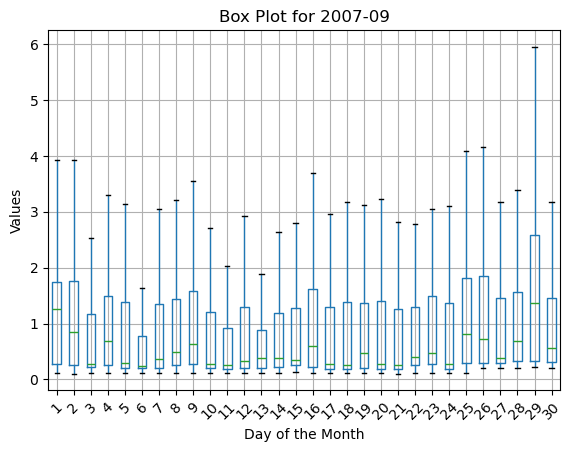

<Figure size 1200x600 with 0 Axes>

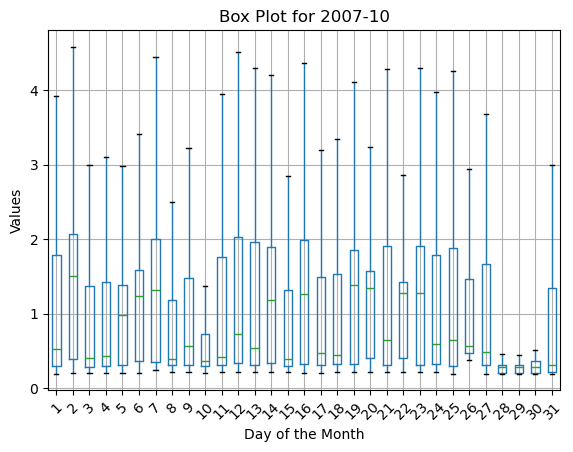

<Figure size 1200x600 with 0 Axes>

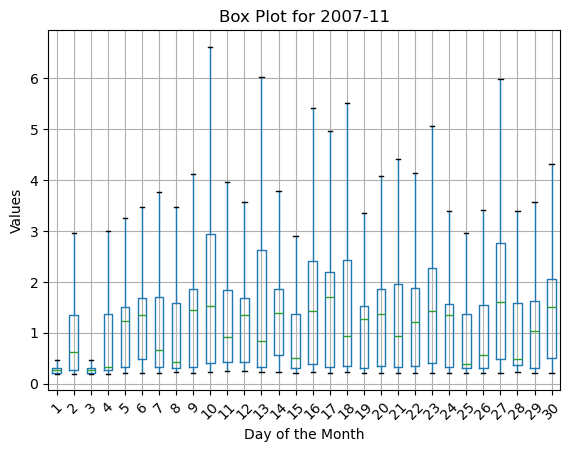

<Figure size 1200x600 with 0 Axes>

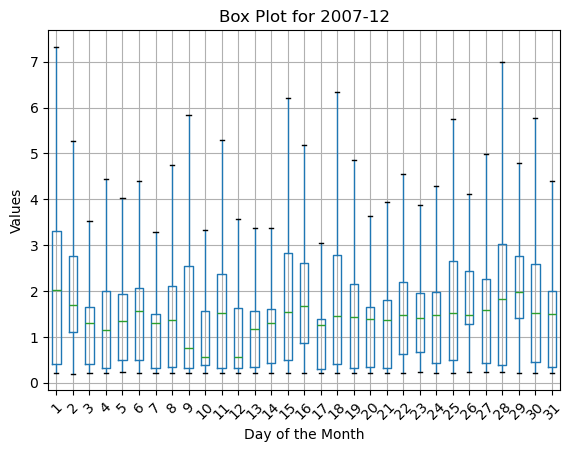

<Figure size 1200x600 with 0 Axes>

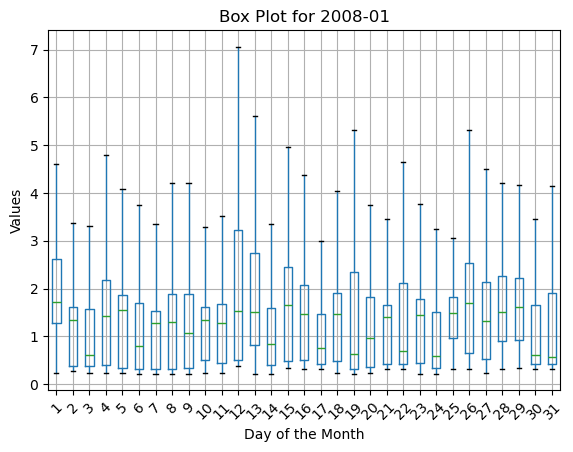

<Figure size 1200x600 with 0 Axes>

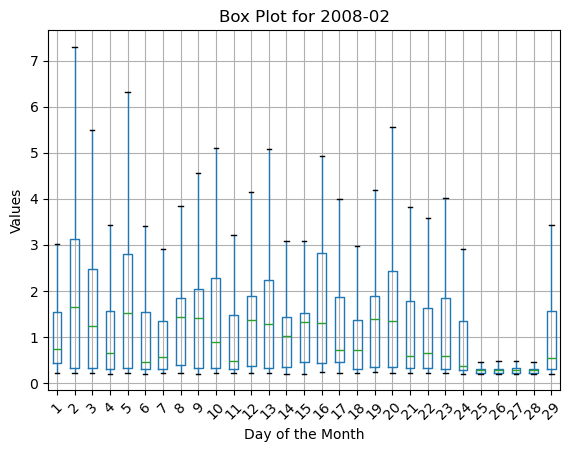

<Figure size 1200x600 with 0 Axes>

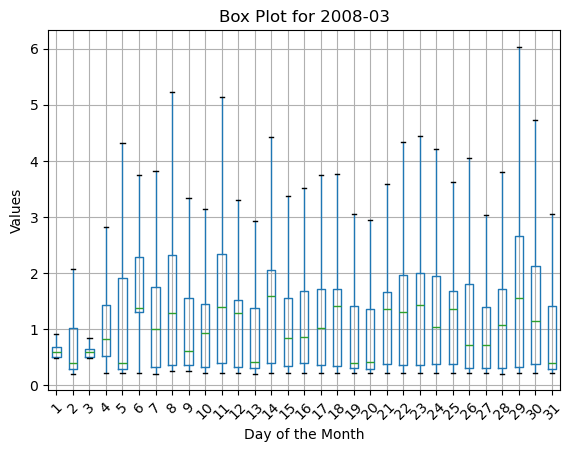

<Figure size 1200x600 with 0 Axes>

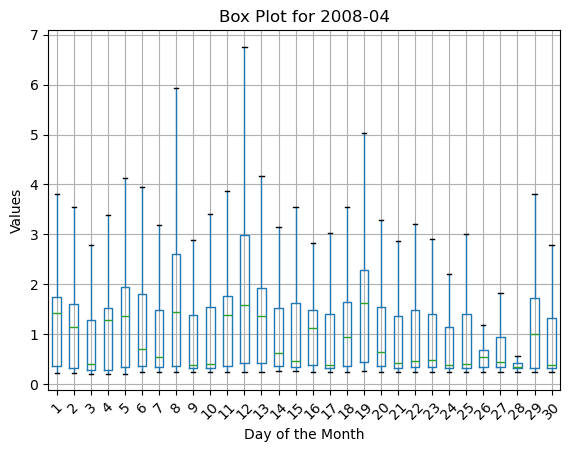

<Figure size 1200x600 with 0 Axes>

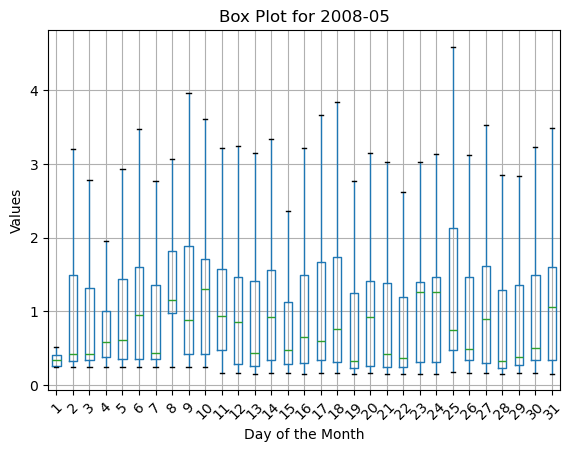

<Figure size 1200x600 with 0 Axes>

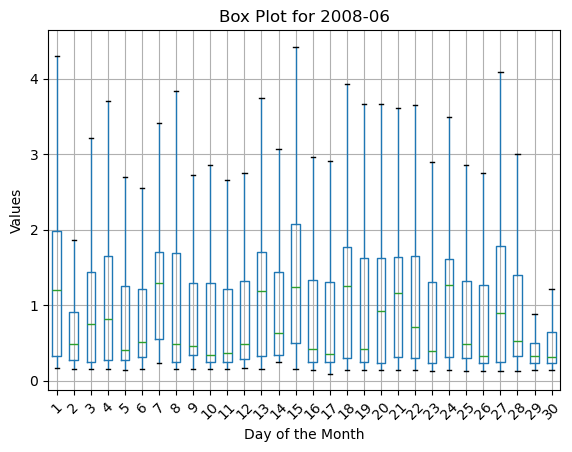

<Figure size 1200x600 with 0 Axes>

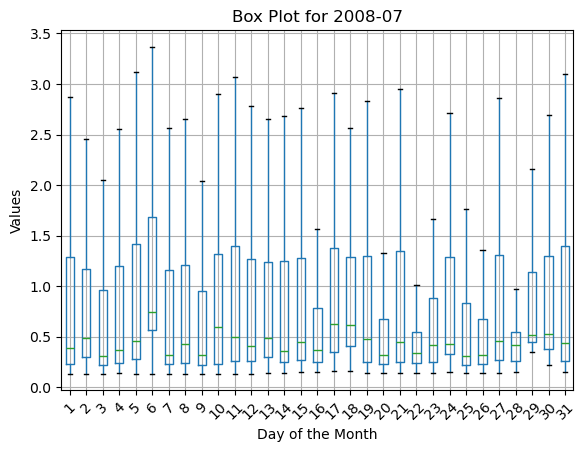

<Figure size 1200x600 with 0 Axes>

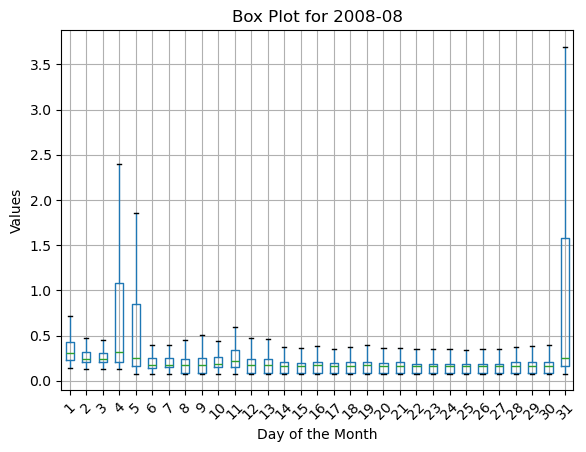

<Figure size 1200x600 with 0 Axes>

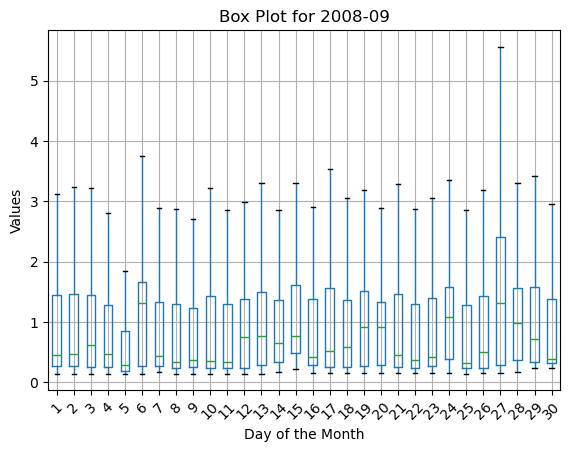

<Figure size 1200x600 with 0 Axes>

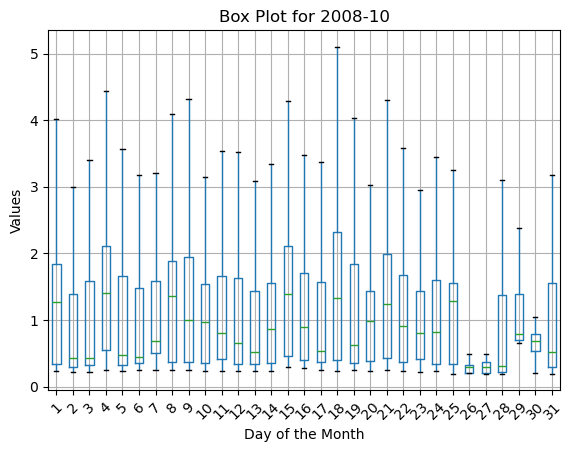

<Figure size 1200x600 with 0 Axes>

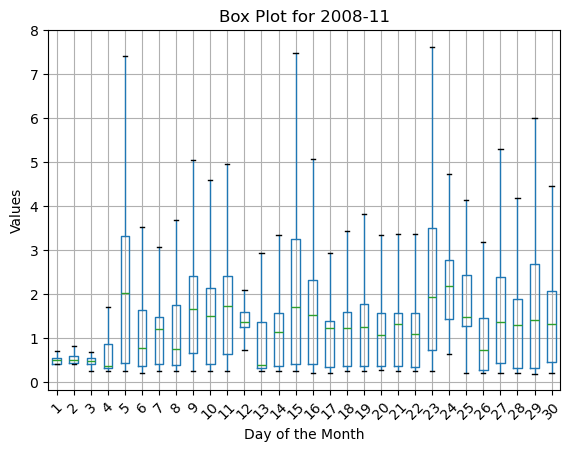

<Figure size 1200x600 with 0 Axes>

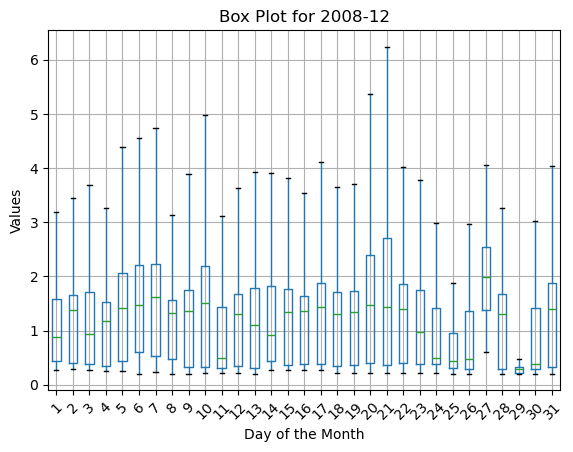

In [13]:
# Ensure 'Date' is a datetime object
data_dropnan['Date'] = pd.to_datetime(data_dropnan['Date'])

# Extract day and month for grouping
data_dropnan['Day'] = data_dropnan['Date'].dt.day
data_dropnan['MonthYear'] = data_dropnan['Date'].dt.to_period('M')  # Year-Month grouping

# Iterate through each unique Month-Year and plot
for month_year in data_dropnan['MonthYear'].unique():
    # Subset the data for the current Month-Year
    monthly_data = data_dropnan[data_dropnan['MonthYear'] == month_year]

    # Create the box plot for each day of the month
    plt.figure(figsize=(12, 6))
    monthly_data.boxplot(column=PREDICTION_TERM, by='Day', grid=False, showfliers=False)
    plt.title(f'Box Plot for {month_year}')
    plt.suptitle('')  # Removes default subtitle
    plt.xlabel('Day of the Month')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [20]:
data_dropnan['Date'] = pd.to_datetime(data_dropnan['Date'])
data_dropnan_median = data_dropnan.groupby(data_dropnan['Date'].dt.date)[PREDICTION_TERM].median()

data_dropnan_median.tail(3)

Date
2008-12-29    0.286
2008-12-30    0.374
2008-12-31    1.407
Name: Global_active_power, dtype: float64

<Figure size 1400x600 with 0 Axes>

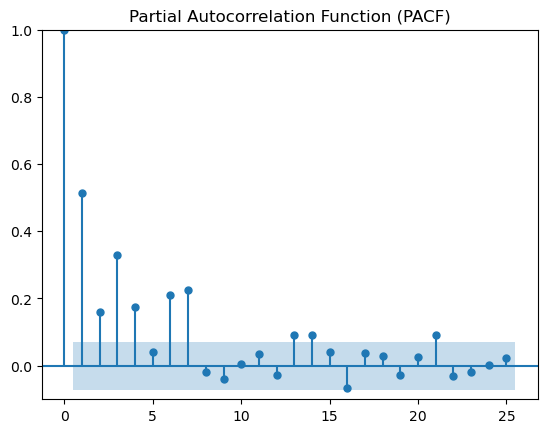

ADF Statistic: -2.9375537413245416
p-value: 0.041152055775579295
The process is stationary.


<Figure size 1400x600 with 0 Axes>

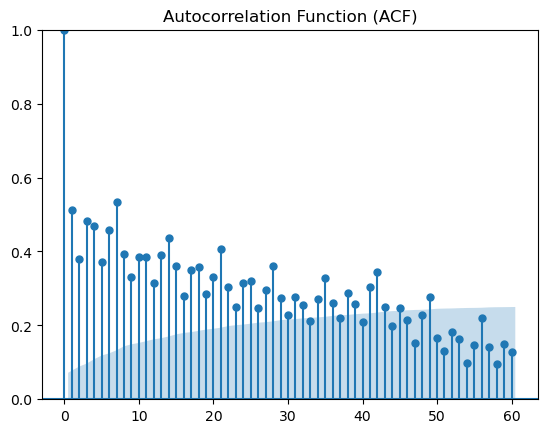

In [25]:
# Plot PACF - p
plt.figure(figsize=(width, height))
plot_pacf(data_dropnan_median, lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Check Stationary - d
result = adfuller(data_dropnan_median)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("The process is stationary.")
else:
    print("The process is not stationary.")

# Plot ACF - q
plt.figure(figsize=(width, height))
plot_acf(data_dropnan_median, lags=60)
plt.ylim(0, 1)
plt.title('Autocorrelation Function (ACF)')
plt.show()

In [37]:
# Train-Test Split
def train_test_split(series, split_ratio=0.8):
    split_index = int(len(series) * split_ratio)
    train, test = series[:split_index], series[split_index:]
    return train, test

In [42]:
# Evaluate ARIMA
def evaluate_arima(train, test, order):
    """
    Fits an ARIMA model and calculates RMSE, MAE, and Accuracy.

    Args:
    - train: Training data (Pandas Series or NumPy array).
    - test: Testing data (Pandas Series or NumPy array).
    - order: ARIMA order tuple (p, d, q).

    Returns:
    - rmse: Root Mean Squared Error.
    - mae: Mean Absolute Error.
    - accuracy: Forecast accuracy as a percentage.
    """
    # Fit ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Forecast for the test set
    forecast = model_fit.forecast(steps=len(test))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)

    # Define accuracy as the percentage of forecasts within 5% of the actual value
    accuracy = np.mean(np.isclose(test, forecast, atol=0.05 * np.abs(test))) * 100

    return rmse, mae, accuracy

# Example Usage
# Assuming `data_dropnan_median` is a Pandas Series
train, test = train_test_split(data_dropnan_median)

# Define ARIMA order (adjust based on ACF/PACF analysis)
arima_order = (7, 0, 30)

# Evaluate the model
rmse, mae, accuracy = evaluate_arima(train, test, arima_order)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

RMSE: 0.5761
MAE: 0.4439
Accuracy: 8.00%


/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### data_imputed1

### data_imputed2